## Data download

The aim is to synthetically create a non-gridded dataset of sea level pressure anomalies. 

To obtain sea level pressure anomalies we first need to get:
1. Climatologies of mean sea level pressure (`msl`/`psl`) over the period 1979--2011 (following IceNet)
2. `msl` data for the training period

Anomalies are then calculated by subtracting the climatological mean for each calendar month from the `msl` data.

### Download monthly means (1979-2011)

We'll download from the CDS dataset [ERA5 monthly averaged data on single levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download). We'll use the CDS API directly, as it is not currently clear how to do so with Anemoi. To use the CDS API you need to have the `cdsapi` package installed and have a `.cdsapirc` file set up under your `$HOME`.

Download only data for the Southern hemisphere. You can do the same for the Northern hemisphere by changing the `area` key to `[90, -180, 0, 180]`, or leave out the key altogether to get global data. The data is saved in `msl_monthly_south_1979_2020.nc`. Provide the full path if you want it saved under another directory, e.g. `../data/msl_monthly_south_1979_2020.nc`.

In [89]:
import cdsapi

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["mean_sea_level_pressure"],
    "year": [
        "1979",
        "1980",
        "1981",
        "1982",
        "1983",
        "1984",
        "1985",
        "1986",
        "1987",
        "1988",
        "1989",
        "1990",
        "1991",
        "1992",
        "1993",
        "1994",
        "1995",
        "1996",
        "1997",
        "1998",
        "1999",
        "2000",
        "2001",
        "2002",
        "2003",
        "2004",
        "2005",
        "2006",
        "2007",
        "2008",
        "2009",
        "2010",
        "2011",
        "2012",
        "2013",
        "2014",
        "2015",
        "2016",
        "2017",
        "2018",
        "2019",
        "2020",
    ],
    "month": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [0, -180, -90, 180],
}

client = cdsapi.Client()
client.retrieve(dataset, request).download("msl_monthly_south_1979_2020.nc")

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): cds.climate.copernicus.eu:443
DEBUG:urllib3.connectionpool:https://cds.climate.copernicus.eu:443 "GET /api/catalogue/v1/messages HTTP/1.1" 200 265
2025-07-29 11:03:08,228 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
DEBUG:urllib3.connectionpool:https://cds.climate.copernicus.eu:443 "GET /api/retrieve/v1/processes/reanalysis-era5-single-levels-monthly-means HTTP/1.1" 200 14981
DEBUG:urllib3.connectionpool:https://cds.climate.copernicus.eu:443 "POST /api/retrieve/v1/processes/reanalysis-era5-single-levels-monthly-means/execution HTTP/1.1" 201 602
2025-07-29 11:03:08,490 INFO Request ID is 6af58619-6390-43bf-9725-41e67822c5a3
INFO:ecmwf.datastores.legacy_client:Request ID is 6af58619-6390-43bf-9725

'msl_monthly_south_1979_2020.nc'

### Download daily data (2014-2020)

Now download the daily `msl` data from ERA5. This data could be downloaded using Anemoi, but it would be in a different resolution and gridding system (o320) than the data downloaded directly using the CDS API or `download_toolbox`, which means you'll have to regrid it. We'll use the `download_era5` command from the `download_toolbox` CLI, which will download ERA5 daily data on a 0.25 x 0.25 degree grid, like the monthly averages downloaded above. You can also download this using the CDS API directly, but `download_toolbox` simply seems a lot faster. You can call the command from this notebook with the following:

In [ ]:
import subprocess

subprocess.run(
    [
        "download_era5",
        "-f",
        "DAY",
        "-o",
        "MONTH",
        "south",
        "2014-01-01",
        "2020-12-31",
        "psl",
        "",
    ]
)

> NB: this will save the data under `/data/era5/psl/south/*nc`, in monthly grouped files. But it will also duplicate them under `/data/era5/day/south/psl/*nc`. Apparently, there's supposed to be a "delete cache" option in the download_toolbox, which I couldn't find.

## Data checks

### Monthly data

In [ ]:
import xarray as xr

ds = xr.open_dataset(
    "../data/monthly_averages/msl_monthly_south_1979_2020.nc", engine="h5netcdf"
)
print(ds)
lat_step = abs(ds.latitude[1].item() - ds.latitude[0].item())
lon_step = abs(ds.longitude[1].item() - ds.longitude[0].item())
print(f"Resolution: {lat_step} x {lon_step}")

In [3]:
import pandas as pd

times = pd.to_datetime(ds.valid_time.values)
print(f"Start: {times.min()}")
print(f"End: {times.max()}")
print(f"Number of months: {len(times)}")
expected = pd.date_range("1979-01-01", "2020-12-01", freq="MS")
missing = expected.difference(times)
print(f"Missing {len(missing)} months")

Start: 1979-01-01 00:00:00
End: 2020-12-01 00:00:00
Number of months: 504
Missing 0 months


### Daily data

In [ ]:
import xarray as xr

ds = xr.open_dataset("../data/era5/south/201405.nc", engine="h5netcdf")
print(ds)
lat_step = abs(ds.latitude[1].item() - ds.latitude[0].item())
lon_step = abs(ds.longitude[1].item() - ds.longitude[0].item())
print(f"Resolution: {lat_step} x {lon_step}")

<xarray.Dataset> Size: 64MB
Dimensions:    (time: 31, latitude: 361, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 248B 2014-05-01T12:00:00 ... 2014-05-31T...
  * latitude   (latitude) float64 3kB 0.0 -0.25 -0.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    psl        (time, latitude, longitude) float32 64MB ...
Resolution: 0.25 x 0.25


In [ ]:
import xarray as xr

ds = xr.open_dataset(
    "../data/monthly_averages/msl_monthly_south_1979_2020.nc", engine="h5netcdf"
)
# Take the mean across years for each calendar month
clim = (
    ds["msl"].groupby("valid_time.month").mean(dim="valid_time")
)  # shape: (12, lat, lon)
len(clim)

In [ ]:
clim.to_dataset(name="msl").to_netcdf(
    "../data/climatology_12_month.nc", engine="h5netcdf"
)

## Calculate anomalies

In [ ]:
clim = xr.open_dataset("../data/climatology_12_month.nc", engine="h5netcdf")

In [40]:
clim

<xarray.Dataset> Size: 25MB
Dimensions:    (latitude: 361, longitude: 1440, month: 12)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 3kB 0.0 -0.25 -0.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    msl        (month, latitude, longitude) float32 25MB ...

In [ ]:
import xarray as xr
import glob
import os

# open clim file if not already loaded from previous
clim = xr.open_dataset("../data/climatology_12_month.nc", engine="h5netcdf")

# Daily files folder
input_folder = "../data/era5/psl/south/"
output_folder = "../data/era5/anom_psl/south/"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get list of daily .nc files
daily_files = sorted(glob.glob(os.path.join(input_folder, "*.nc")))

for f in daily_files:
    print(f"Processing {f}")
    ds_daily = xr.open_dataset(f, engine="h5netcdf")

    # Extract month from the first time value
    month = ds_daily["time"].dt.month[0].item()

    # Select the corresponding climatology slice
    clim_month = clim.sel(month=month)

    # Subtract climatology from daily values
    anomaly = ds_daily["psl"] - clim_month["msl"]

    # Preserve original filename, save under new folder
    filename = os.path.basename(f)
    out_file = os.path.join(output_folder, filename)

    # Save anomaly
    anomaly.to_dataset(name="psl_anom").to_netcdf(out_file, engine="h5netcdf")

    print(f"Saved {out_file}")

## Visualize

In [ ]:
ds_anom = xr.open_dataset("../data/era5/anom_psl/south/201401.nc", engine="h5netcdf")
ds_mls = xr.open_dataset("../data/era5/psl/south/201401.nc", engine="h5netcdf")

psl_anom = ds_anom["psl_anom"].isel(time=0) / 100  # Convert Pa → hPa
ds_mls = ds_mls["psl"].isel(time=0) / 100  # Convert Pa → hPa

In [2]:
antarctic_extent = [-180, 180, -90, -60]
arctic_extent = [-180, 180, 60, 90]

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean


def plot_msl(msl_data, title):
    is_arctic = msl_data.latitude.mean().item() > 0
    proj = ccrs.NorthPolarStereo() if is_arctic else ccrs.SouthPolarStereo()

    plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=proj)

    # Set appropriate extent for polar views
    if is_arctic:
        ax.set_extent(arctic_extent, crs=ccrs.PlateCarree())
    else:
        ax.set_extent(antarctic_extent, crs=ccrs.PlateCarree())

    # Basemap features
    ax.coastlines(resolution="50m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    # ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5)

    # Pressure levels
    levels = np.linspace(msl_data.min().item(), msl_data.max().item(), 30)
    cs = ax.contourf(
        msl_data.longitude,
        msl_data.latitude,
        msl_data,
        levels=levels,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.diff,
        extend="both",
    )

    # Colorbar
    plt.colorbar(cs, orientation="horizontal", pad=0.05, aspect=50, label="MSLP (hPa)")

    ax.set_title(title)

    # Apply tight layout
    plt.tight_layout()
    plt.show()

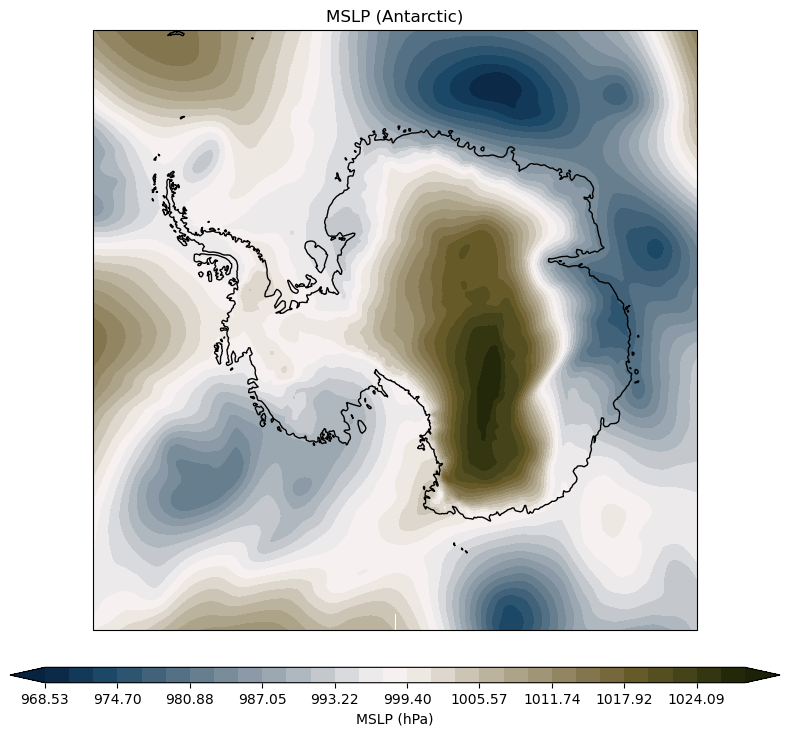

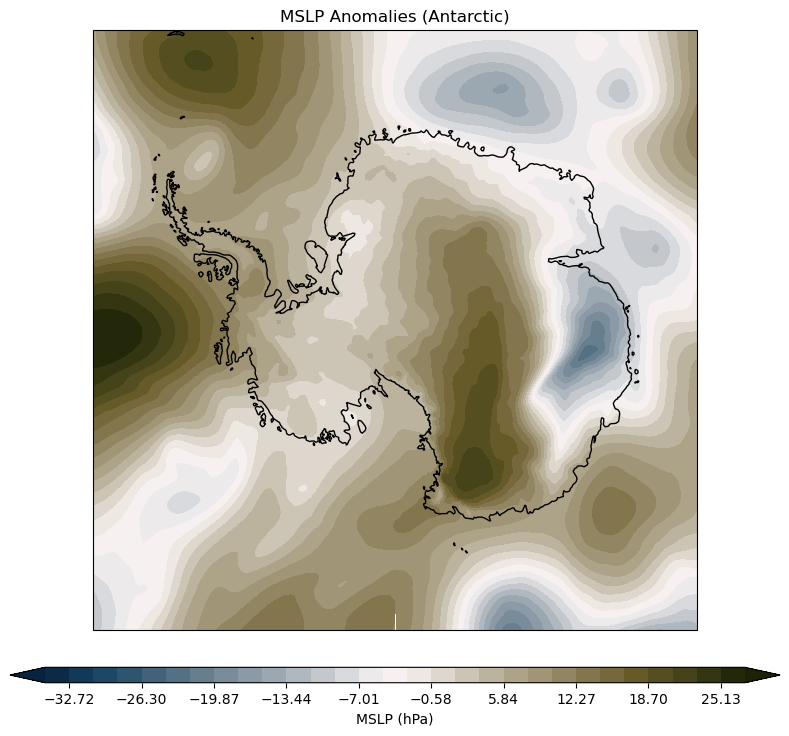

In [5]:
plot_msl(ds_mls, title="MSLP (Antarctic)")
plot_msl(psl_anom, title="MSLP Anomalies (Antarctic)")